In [49]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.circuit.library import QFT

import numpy as np
import matplotlib.pyplot as plt

In [128]:
evaluation_qubits = 5

probability = 0.4
theta = 2 * np.arcsin(np.sqrt(probability))

evaluation_registry = QuantumRegister(evaluation_qubits, 'evaluation')
a_registry = QuantumRegister(1, 'a')

## First with the Qiskit function

In [129]:
qc =  QuantumCircuit(a_registry)
qc.ry(theta, a_registry[0])
backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

{'0': 0.6, '1': 0.4}


In [130]:
ae = AmplitudeEstimation(evaluation_qubits, qc)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'))

In [131]:
result

{'a_estimation': 0.4024548, 'confidence_interval': [0.3978474915821541, 0.40709875050019434], 'estimation': 0.4024548, 'num_oracle_queries': 31744, 'ml_value': 0.40533939320026086, 'mapped_a_samples': [0.2222149, 0.4024548, 0.5975452, 0.6913417], 'probabilities': [0.0009765625, 0.9970703125, 0.0009765625, 0.0009765625], 'shots': 1024, 'mle': 0.40533939320026086, 'circuit_result': {'10011': 527, '11011': 1, '11100': 494, '11101': 1, '01010': 1}, 'a_samples': [(0.2222149, 0.0009765625), (0.4024548, 0.9970703125), (0.5975452, 0.0009765625), (0.6913417, 0.0009765625)], 'y_measurements': [(7, 0.482421875), (10, 0.0009765625), (23, 0.0009765625), (25, 0.5146484375), (27, 0.0009765625)], 'mapped_values': [0.2222149, 0.4024548, 0.5975452, 0.6913417], 'max_probability': 0.9970703125}

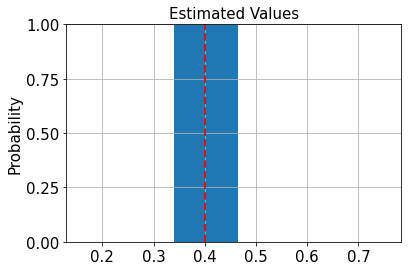

In [132]:
# plot estimated values
plt.bar(result['mapped_a_samples'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

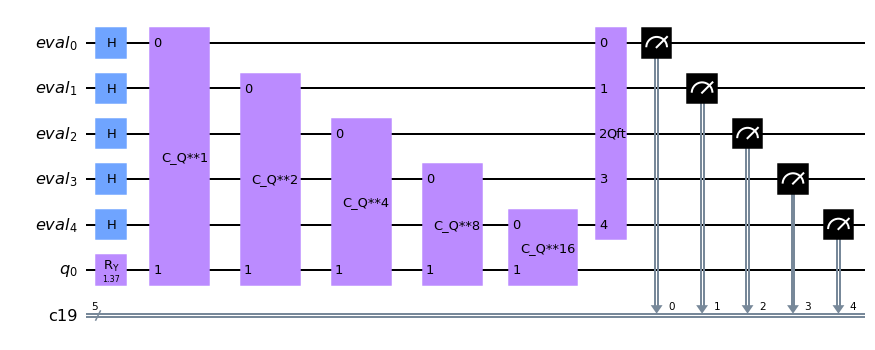

In [133]:
ae._circuit.draw('mpl')

## Design our own AE

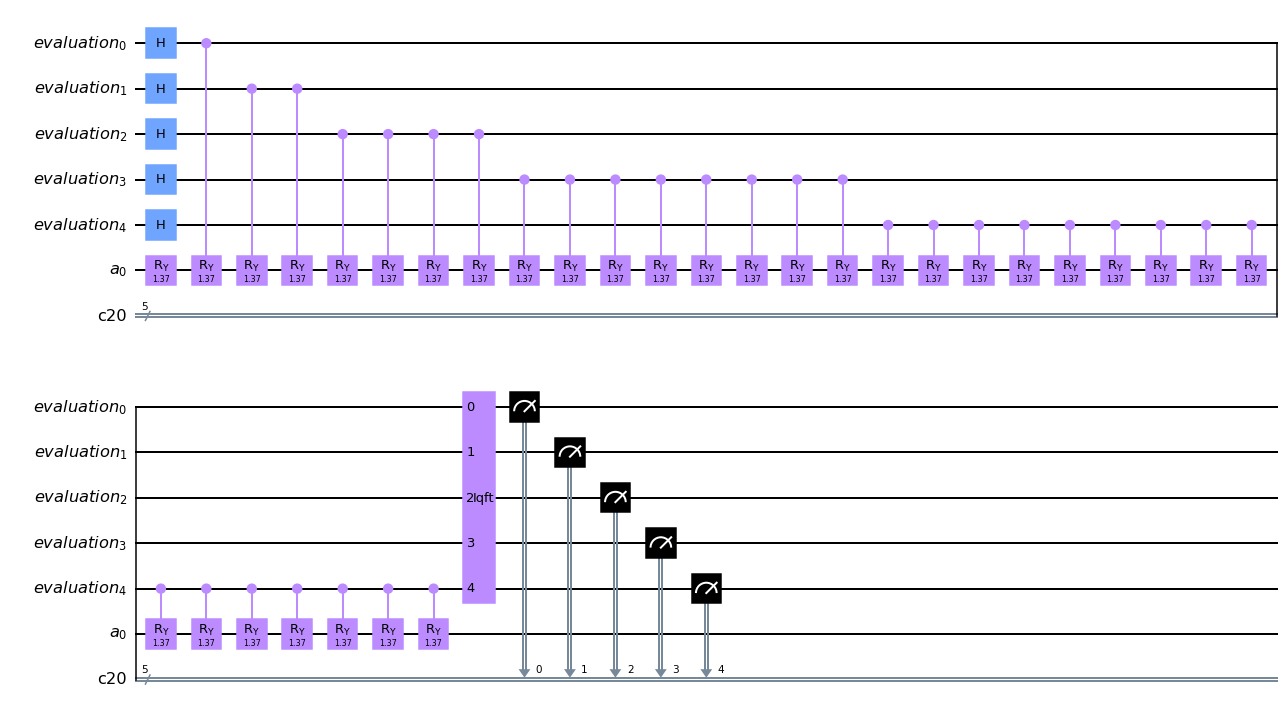

In [134]:
cr = ClassicalRegister(evaluation_qubits)
qc = QuantumCircuit(evaluation_registry, a_registry, cr)

qc.ry(theta, a_registry[0])
qc.h(range(evaluation_qubits))

# Do the controlled-U operations:
repetitions = 1
for counting_qubit in range(evaluation_qubits):
    for i in range(repetitions):
        qc.cry(theta, counting_qubit, evaluation_qubits);
    repetitions *= 2

qc.append(QFT(evaluation_qubits).inverse(), range(evaluation_qubits))

qc.measure(range(evaluation_qubits), cr)
qc.draw('mpl')

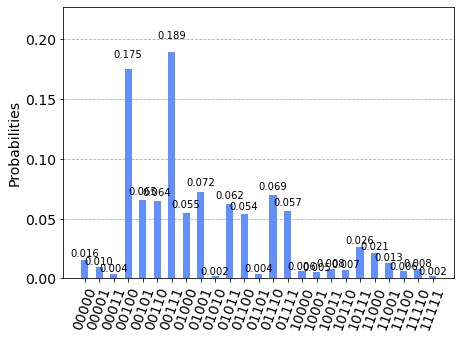

In [135]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()

plot_histogram(counts)

In [136]:
print(max(counts, key=counts.get))
print(int(max(counts, key=counts.get),2))
estimated_probability = int(max(counts, key=counts.get),2) / 2**evaluation_qubits
print("Estimated Probability: ", estimated_probability)
print("Real Probability: ", probability)

00111
7
Estimated Probability:  0.21875
Real Probability:  0.4


In [137]:
for i in counts:
    estimated_probability = int(i,2) / 2**evaluation_qubits
    print(i, " : ", counts[i], " - ", estimated_probability)

00000  :  16  -  0.0
00001  :  10  -  0.03125
10000  :  6  -  0.5
10001  :  5  -  0.53125
10011  :  8  -  0.59375
10110  :  7  -  0.6875
10111  :  27  -  0.71875
11000  :  22  -  0.75
11001  :  13  -  0.78125
11100  :  6  -  0.875
11110  :  8  -  0.9375
11111  :  2  -  0.96875
00011  :  4  -  0.09375
00100  :  179  -  0.125
00101  :  67  -  0.15625
00110  :  66  -  0.1875
00111  :  194  -  0.21875
01000  :  56  -  0.25
01001  :  74  -  0.28125
01010  :  2  -  0.3125
01011  :  64  -  0.34375
01100  :  55  -  0.375
01101  :  4  -  0.40625
01110  :  71  -  0.4375
01111  :  58  -  0.46875
